This notebook follows the same pipeline laid out in the "**Decot, Namboodiri et al. DA evoked data analysis**" notebook. So please check that notebook out first. Most of the changes are due to the large size of the pairing data. Hence, this notebook optimizes the pipeline for memory consumption. Most functions in this notebook are just copied over and modified if necessary from that notebook. The files needed to run this notebook should have been downloaded as part of running the first code cell of that notebook.


## Import all required modules

In [29]:
import scipy.io as sio
import scipy.stats as stats
import numpy as np
import os
import errno
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
% matplotlib inline

import seaborn as sns

import h5py
from multiprocessing import Pool, cpu_count

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd


## Visualize raw data

First, we will define different functions for this step. The actual implementation of the visualization will be done later in the notebook. 

The data is organized as an HDF5 file with the following levels: 
1. Condition (CHR2 or EYFP) 
2. Animals

In [2]:
def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def calculate_shape_of_data(f):
    #This function calculates the shape of each trial's data
    
    #Parameters:
    # 1. filehandle to the HDF5 file
    
    #Returns: Shape of each trial's data

    conditions = f['/'].keys()
    animals = f['/'][conditions[0]].keys()
    sample_data = f['/'][conditions[0]][animals[0]]
    (numx, numy, numz, numt) = sample_data.shape
    
    return (numx, numy, numz, numt)

def calculate_response_preMION(MIONdata, 
                               condition, 
                               animal, 
                               indices_for_windows):
    # This function calculates the preMION injection response so as to calculate the
    # %CBV value for the response around stimulation using the equation
    # %CBV = ln(S_baseline/S(t))/ln(S_preMION/S_baseline)
    
    #Parameters:
    #   1. The handle to the HDF5 file containing the MION injection data to calculate %CBV
    #   2. condition: either CHR2 or EYFP
    #   3. animal id
    #   4. indices_for_windows is the specification of time windows of interest. In this experiment,
    #      there is a baseline period between time=0 and time=20, followed by the first stimulation
    #      between 20 to 30, followed by the post-stimulation period of the first stimulation, followed
    #      by the second stimulation between 60 and 70, followed by the post-stimulation period of 
    #      the second stimulation from 70 to 100. 100 is also equal to numt, the total number of time
    #      samples. Hence, in this case, indices_for_windows = [0, 20, 30, 60, 70, 100]. 
    
    #      For the preMION, we will calculate the preMION response as the mean response during the 
    #      first indices_for_windows[0] time points.
    
    data = MIONdata[condition][animal]
    temp = np.mean(data[:,:,:,:indices_for_windows[1]], axis=3)
    temp[temp==0]=np.nan
    response_preMION = np.nanmean(temp)
    return response_preMION

def load_saved_meansignal(pathtoresult):
    handle = h5py.File(pathtoresult,'r')        
    return handle
    
def perform_meansignal_calculation(f, 
                                   (numx,numy,numz,numt),
                                   pathtoresult,
                                   MIONdata,
                                   indices_for_windows):
    
    def access(f, condition, animal, MIONdata, indices_for_windows):
        response_preMION = calculate_response_preMION(MIONdata, condition, animal, indices_for_windows)
        fulldata = f['/'][condition][animal]
        
        temp = np.mean(fulldata[:,:,:,:indices_for_windows[1]], axis=3)   
        temp[temp==0]=np.nan
        response_baseline = temp
        meanresponse_baseline = np.nanmean(temp)
        signal = (np.tile(np.expand_dims(response_baseline, axis=3), (1,1,1,numt)) - fulldata)
        normalization = (response_preMION - meanresponse_baseline)
        normalizedsignal = signal/normalization
                    
        return normalizedsignal
    
    handle = h5py.File(pathtoresult,'a')
    
    conditions = f['/'].keys()
    #mean_data_for_condition = {}
    for condition in conditions:
        animals = f['/'][condition].keys()
        sumofdata = np.zeros((numx,numy,numz,numt))
        for animal in animals:
            sumofdata += access(f,condition,animal, MIONdata, indices_for_windows)
        handle.create_dataset(condition,data = sumofdata/len(animals))
        #mean_data_for_condition[condition] = sumofdata/len(animals)
    handle.close()
    
    handle = h5py.File(pathtoresult,'r') 
    return handle
            
def calculate_meansignal_across_animals(f, 
                                        (numx,numy,numz,numt),
                                        pathtoresult,
                                        MIONdata,
                                        indices_for_windows):
    # This function calculates the mean signal per voxel across all animals and all runs. Since all animals'
    # data are too big to load into memory, we will do this as a sum operation followed by division by 
    # number of animals. Also, we will write the output of this function to a file. If that file is present,
    # this operation will not be repeated.
    
    # Parameters:
    #   1. Handle to the HDF5 file containing the data. Defined later
    #   2. Tuple of the shape of the data from each trial in the order 
    #            a. number of x voxels, b. number of y voxels, c. number of z voxels, d. number of time samples
    #   3. The path to the result to save the file.
    
    # Returns: Mean data for all voxels across all animals for both conditions as a dictionary.
    
    if os.path.isfile(pathtoresult):
        handle = load_saved_meansignal(pathtoresult)
    else:
        handle = perform_meansignal_calculation(f, (numx,numy,numz,numt), pathtoresult, MIONdata, indices_for_windows)

    return handle

def plot_traces_for_each_voxel(data, 
                               indices_for_windows, 
                               sortby='stimresponse',
                               periodofinterest='poststim', 
                               numvoxelstoshow = 5000,
                               pca_results_paths=None, 
                               sortbypc=None):
    # Plots the traces for each voxel. One could use this function for visualizing data from
    # individual animals. But here, we use it to visualize raw voxel traces for the normalized
    # mean data across all animals and runs. This is calculated by the above two functions.
    # The voxels can be sorted by either stimulus response or PCA weights.
    # Obviously, sorting by PCA weights can be done only if the corresponding PCA has been 
    # done. We will calculate this later. But at that stage, we can call this function 
    # to sort the voxel traces by the voxel's weight on any PC.

    #Parameters:
    #   1. Handle to the file containing the data to plot. Each condition's data 
    #      has shape (numx,numy,numz,numt)
    #   2. indices_for_windows is the specification of time windows of interest. See above
    #   3. sortby decides whether the voxels should be sorted by stimulus response of PC weights.
    #      sortby='stimresponse' or 'pcweights'. Default is stimresponse
    #   4. Period of interest to sort the voxels by if sortby = 'stimresponse'.
    #      Can be either 'stim' or 'poststim'. For each case, the mean response in that period
    #      will be used to sort the voxels.
    #   5. Number of voxels to show in the plot.
    #   6. pca_results_path: Dictionary containing the paths where the PCA results (pickled files) for 
    #      each condition are stored.
    #   7. sortbypc is the principal component whose weights should be used to sort the voxels
    #      if sortby=='pcweights'
    
    # Returns: Figure handle for the plot. Useful for saving the figure later.
    
    
    conditions = data.keys()
    conditions.sort()
    (numx,numy,numz,numt)=data[conditions[0]].shape
    numvoxels = numx*numy*numz
    
    #For plotting, we want to set the colorbar minimum and maximum as the values across all conditions
    #This is first calculated, along with the sorting order for the voxels
    
    fig, allax = plt.subplots(1,2, sharey='row', figsize=(16,20))
    
    #Define the periods of interest: stimperiod and poststimperiod
    poststimperiod = np.arange(indices_for_windows[2],indices_for_windows[3])
    stimperiod = np.arange(indices_for_windows[1],indices_for_windows[2])
    allrows = np.arange(numx*numy*numz) #useful for indexing all rows later
    
    flattened_data = {} #Will contain spatially flattened data
    sortvoxels = {} #Will contain sorting order for the voxels
        
    def calculate_cbarlims_sortvoxels():
        
        cmin = np.nan*np.ones((len(conditions),1))
        cmax = np.nan*np.ones((len(conditions),1))
        for c, condition in enumerate(conditions):
            flattened_data[condition] = np.reshape(data[condition], (numvoxels, numt))

            if sortby=='stimresponse' and periodofinterest=='poststim':
                sortvoxels[condition] = np.argsort(
                    np.nanmean(flattened_data[condition][np.ix_(allrows,poststimperiod)], axis=1))
            elif sortby=='stimresponse' and periodofinterest=='stim':
                sortvoxels[condition] = np.argsort(
                    np.nanmean(flattened_data[condition][np.ix_(allrows,stimperiod)], axis=1))
            elif sortby=='pcweights':                
                if sortbypc is None:
                    raise Exception('Please specify which PC to use to sort the voxels')
                if pca_results_paths is None:
                    raise Exception('Please specify the paths to the pickle file containing PCA results')
                    
                pca = joblib.load(pca_results_paths[condition])
                voxel_components = pca.components_.T
                sortvoxels[condition] = np.argsort(np.abs(voxel_components[:,sortbypc]))

            cmin[c] = np.amin(flattened_data[condition][sortvoxels[condition][-numvoxelstoshow:],:])
            cmax[c] = np.amax(flattened_data[condition][sortvoxels[condition][-numvoxelstoshow:],:]) 

        cmin = np.amin(cmin)
        cmax = np.amax(cmax)
        
        return cmin, cmax, sortvoxels
    
    cmin, cmax, sortvoxels = calculate_cbarlims_sortvoxels()
    
    # Create the plots
    for c, condition in enumerate(conditions):
        allax[c].set_title(condition)
        ax = allax[c]   
        voxelorder = sortvoxels[condition][-numvoxelstoshow:]
        sns.heatmap(flattened_data[condition][voxelorder[::-1],:], 
                    ax=ax, cmap=plt.get_cmap('viridis'), vmin=cmin, vmax=cmax, linewidth=0)
        for epochindex in range(1,indices_for_windows.shape[0]-1):
            ax.plot(indices_for_windows[epochindex]*np.array([1, 1]), [0, numvoxelstoshow], '--k', linewidth=1)
        ax.grid(b=False)  
        
        
        allax[c].set_xlabel('Time (s)')
        allax[c].set_xticks(range(0, indices_for_windows[-1]+1, 100))
        allax[c].set_xticklabels([str(a) for a in range(0, indices_for_windows[-1]+1, 100)])
        
    
    allax[0].set_ylabel('Voxel number')
    allax[0].set_yticks(range(0, numvoxelstoshow, numvoxelstoshow/10))
    allax[0].set_yticklabels([str(numvoxelstoshow-a) for a in range(0, numvoxelstoshow, numvoxelstoshow/10)])
    
    fig.tight_layout()
    
    return fig

Now that the above functions are declared, we are ready to use them to visualize the data.

First, we need to set all the parameters of interest. They are:
1. **indices_for_windows**: the specification of time windows of interest. In this experiment, there is a baseline period between time=0 and time=20, followed by the first stimulation between 20 to 30, followed by a post-stimulation period of 70s. The 10s stim + 70s rest repeats 19 more times. Hence, in this case, indices_for_windows = [0, 20, 30, 100, 110, 180,....,1620]
2. **working_directory**  : This will be the local working directory where all data and results are stored.
3. **f**                  : file handle for the HDF5 file containing the data
4. **freqofinterest**     : String representing the frequency of interest

In [3]:
temp = [0, 20, 30, 100, 120]
for i in range(20):
    temp.append(temp[-1]+10)
    temp.append(temp[-1]+70)
temp.append(temp[-1]+20);temp.append(temp[-1]+10);temp.append(temp[-1]+70)
    
indices_for_windows = np.array(temp)

working_directory = '/home/stuberlab/temp/heather data working directory'

f = h5py.File(os.path.join(working_directory, 'pawstim_pairing_data.hdf5'),'r') #Read-only  

results_directory = os.path.join(working_directory,'pawstimpairingresults')
mkdir_p(results_directory)

path_to_meandata = os.path.join(results_directory,'mean_data_for_condition.hdf5')

(numx, numy, numz, numt) = calculate_shape_of_data(f)

MIONdata = h5py.File(os.path.join(working_directory, 'pawstim_MIONdata.hdf5'),'r') #Read-only 

In [4]:
calculate_meansignal_across_animals(f, (numx,numy,numz,numt), path_to_meandata, MIONdata, indices_for_windows)

<HDF5 file "mean_data_for_condition.hdf5" (mode r)>

## Combine pre and post pairing data with the pairing data before PCA

When doing PCA, it is useful to combine the pre and post pairing data along with the pairing data to get a large matrix in the temporal sequence pre-pairing, during pairing and post-pairing. This way, one can evaluate the change in stimulation amplitude through the whole session.

In [5]:
def combine_pre_during_post_data():
    if not os.path.isfile(os.path.join(working_directory, 'pawstimpairingresults','mean_data_for_condition_ALL.hdf5')):
        
        prepostdata = h5py.File(os.path.join(working_directory, 'pawstimresults','mean_data_for_condition.hdf5'),
                                'r')
        duringdata = h5py.File(os.path.join(working_directory, 'pawstimpairingresults','mean_data_for_condition.hdf5'),
                                'r')

        alldata = h5py.File(os.path.join(working_directory, 'pawstimpairingresults','mean_data_for_condition_ALL.hdf5'),
                                'a')
        for condition in duringdata.keys():
            temp = np.concatenate((np.nan_to_num(prepostdata[condition]['pre']),
                                   np.nan_to_num(duringdata[condition]),
                                   np.nan_to_num(prepostdata[condition]['post'])),axis=3)
            print temp.shape
            alldata.create_dataset(condition, data=temp)
        alldata.close()
    alldata = h5py.File(os.path.join(working_directory, 'pawstimpairingresults','mean_data_for_condition_ALL.hdf5'),
                                'r')
    return alldata

In [6]:
alldata = combine_pre_during_post_data()

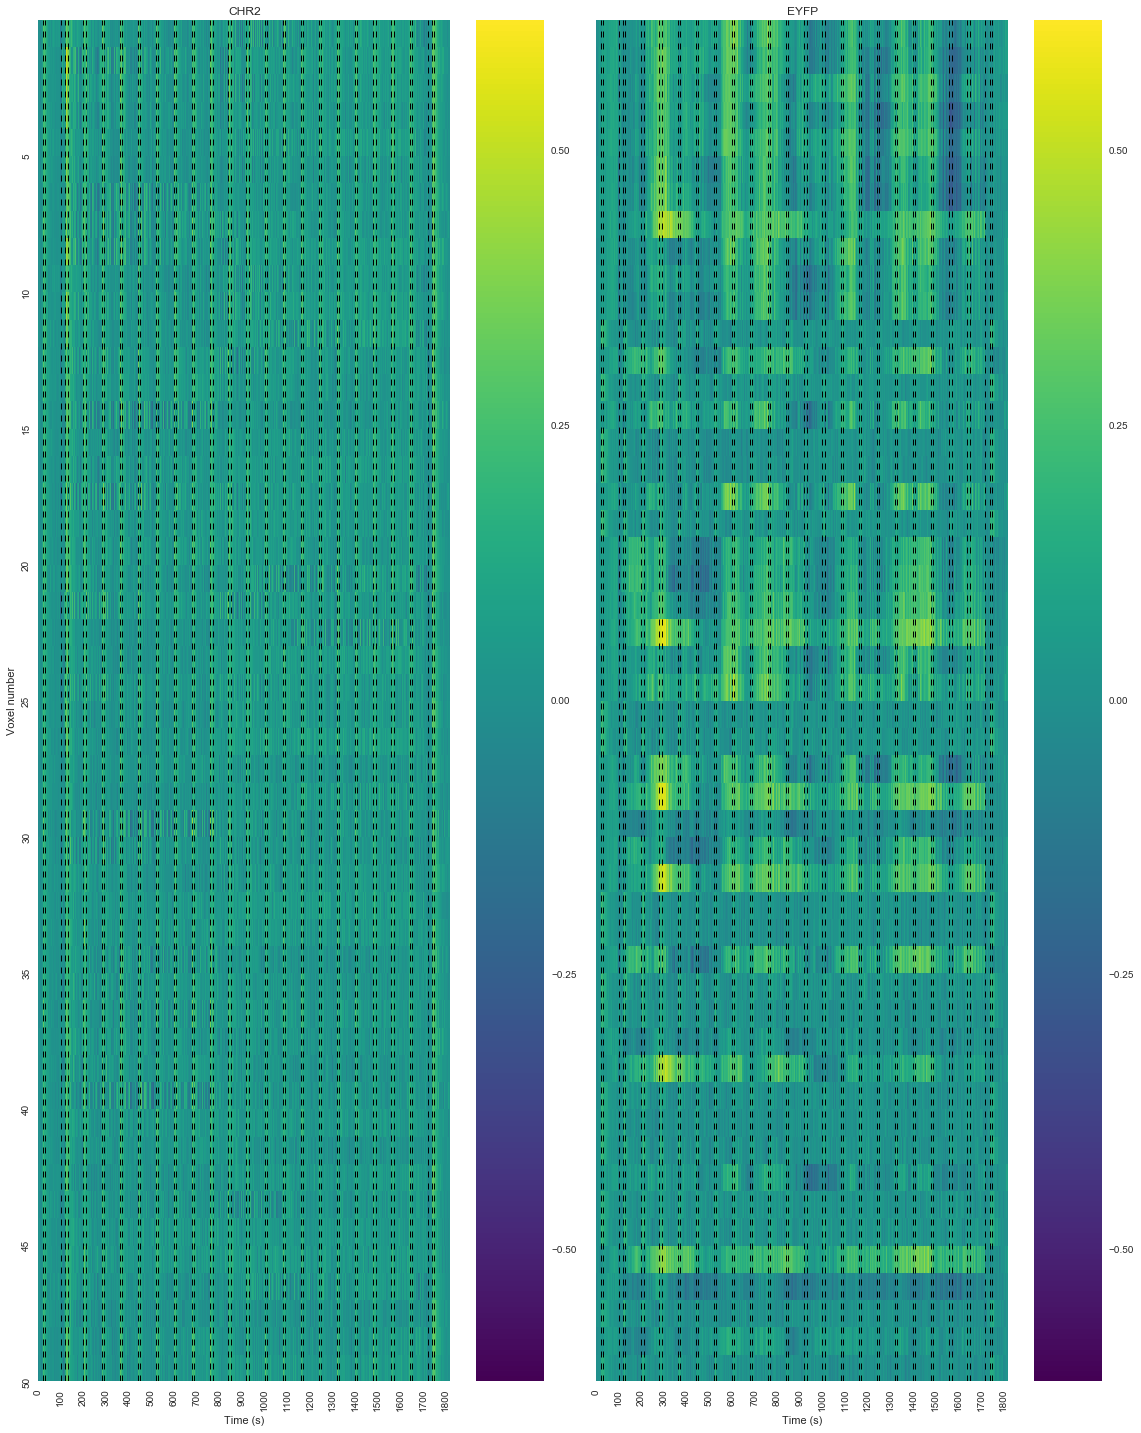

In [10]:
fig = plot_traces_for_each_voxel(alldata, indices_for_windows, numvoxelstoshow=50, periodofinterest='poststim')

At this point, you can save the figure if you want, to the path you set below.

In [11]:
numvoxelstoshow = 50
sortby = 'Stimresponse_stimperiod'
path_to_save = os.path.join(results_directory,'Top%dvoxels_pawstim_sortedby%s_ordering'%(numvoxelstoshow,
                                                                                                sortby))
fig.savefig(path_to_save + '.png', format='png', dpi=300)
#fig.savefig(path_to_save + '.pdf', format='pdf')

In [ ]:
reset_selective fig

## Convert data into PCA space

Now, we will do PCA on the data to get an unbiased factorization of the data. The PCA is done to compress the dimensionality of the voxels. These first set of functions are useful for performing the PCA and visualizing their raw results. Additional functions for advanced visualization will be defined later.

In [20]:
def preprocess_data(data):
    # This function flattens the data along the spatial dimensions. So size of data will
    # change from (numx, numy, numz, numt) to (numx*numy*numz, numt)
    
    #Parameters:
    #   1. The data to be flattened
    
    # Returns: Flattened data
    flattened_data = np.reshape(data,(np.prod(data.shape[:-1]), data.shape[3]))
    return flattened_data

def PCA_decomp(data, 
               pca_results_path, 
               indices_for_windows,
               min_variance_explained=0.8):
    # This function is called to do PCA decomposition. This checks if the PCA has already
    # been done by checking if a pickled file exists in pca_results_path. If this file
    # exists, it just loads those results. Otherwise, it performs the PCA decomposition.
    
    #Parameters:
    #   1. The data to perform PCA on. Shape: (numx, numy, numz, numt)
    #   2. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    #   3. The minimum amount of variance that should be explained. The number of 
    #      PCs stored will be determined by this number.
    
    # Returns: Data in PCA space
    
    if os.path.isfile(pca_results_path): #has PCA already been done?
        return transform_from_loadedpca(data, pca_results_path)
    else:
        return perform_PCA_decomp(data, pca_results_path, indices_for_windows, min_variance_explained)

def transform_from_loadedpca(data, 
                             pca_results_path):
    # This function transforms inputted data based on stored PCA results for that data.
    
    #Parameters:
    #   1. The data on which PCA was performed.
    #   2. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    
    # Returns: Data in PCA space
    transformed_data_path = os.path.join(results_directory, 'transformed_data.h5')
    if not os.path.isfile(transformed_data_path):
        transformed_data_handle = h5py.File(transformed_data_path,'x')
    transformed_data_handle = h5py.File(transformed_data_path,'r')
    if pca_results_path in transformed_data_handle:
        return transformed_data_handle[pca_results_path]
    else:
        transformed_data_handle.close()
        transformed_data_handle = h5py.File(transformed_data_path,'a')
        return perform_transformation(data, pca_results_path, transformed_data_handle)    
    
def perform_transformation(data,
                           pca_results_path,
                           transformed_data_handle):
    flattened_data = preprocess_data(data)
    pca = load_calculated_pca(pca_results_path)
    compressed_data = pca.transform(flattened_data.T).T #transform back to shape n_components x n_timepoints
    transformed_data_handle.create_dataset(pca_results_path, data=compressed_data)
    transformed_data_handle.close()
    return compressed_data

def perform_PCA_decomp(data, 
                       pca_results_path, 
                       indices_for_windows,
                       min_variance_explained=0.8):
    # This function performs the PCA decomposition. This is called only if 
    # there aren't any results from a previous run stored in pca_results_path.
    
    #Parameters:
    #   1. The data to perform PCA on. Shape: (numx, numy, numz, numt)
    #   2. pca_results_path: Path to where the PCA result should be stored.
    #   3. The minimum amount of variance that should be explained. The number of 
    #      PCs stored will be determined by this number.
    
    # Returns: Data in PCA space
    
    flattened_data = preprocess_data(data)
    pca = PCA(n_components=min_variance_explained)
    pca.fit(flattened_data.T) 
    compressed_data = pca.transform(flattened_data.T).T #transform back to shape n_components x n_timepoints
    pca, compressed_data = standardize_pca_sign(pca, compressed_data, indices_for_windows)
    joblib.dump(pca, pca_results_path)
    return compressed_data

def load_calculated_pca(pca_results_path):
    # This function loads the calculated PCA object.
    
    #Parameters:
    #   1. pca_results_path: Path to where the PCA result would have been stored
    #                        if PCA has already been performed for this data.
    
    # Returns: sklearn PCA object
    pca = joblib.load(pca_results_path)
    return pca

def standardize_pca_sign(pca, 
                         compressed_data,
                         indices_for_windows,
                         criterion='positivestimresponse'):
    # The PCs are only defined upto a negative sign, i.e. a 180 degree rotated PC vector
    # is equivalently a PC vector. This function prevents this ambiguity by enforcing
    # the sign of each PC to be such that the derivative of the trace is positive at the 
    # onset of the first stimulation. Other forms of standardization could also be used.  
    # Obviously, this works only for this current experiment with stimulation. In case
    # there is no stimulation, you could set the criterion to "positiveslope" in which 
    # case the function will ensure that the PC's trace has a positive linear trend 
    # through the recording.
    
    #Parameters:
    #   1. The sklearn PCA object.
    #   2. compressed_data: Data in PCA space
    #   3. indices for windows. Explained above
    #   4. criterion for standardization. Set to positivestimresponse to ensure that
    #      the PCs have a positive stimulation response.
    
    # Returns: Sign standardized input parameters
    for pc in range(compressed_data.shape[0]):
        trace = compressed_data[pc,:].T
        if criterion=='positivestimresponse':
            if np.diff(trace)[indices_for_windows[1]]<0:
                compressed_data[pc,:] = -compressed_data[pc,:]
                pca.components_[pc,:] = -pca.components_[pc,:]  
        elif criterion=='positiveslope':
            time = np.arange(trace.shape[0]).T
            time = sm.add_constant(time)
            lm = sm.OLS(trace, time).fit()
            if lm.params[1] < 0: #if slope < 0, flip the PC vector and the trace
                compressed_data[pc,:] = -compressed_data[pc,:]
                pca.components_[pc,:] = -pca.components_[pc,:]
    return pca, compressed_data

def extract_pc_vectors(pca_results_path, 
                       (numx, numy, numz)):
    # This function is used to extract the PC vectors from the stored results 
    # in pca_results_path and reshapes them to the original voxel tiling.
    
    #Parameters:
    #   1. PCA results path
    
    # Returns: pca_vectors
    
    pca = load_calculated_pca(pca_results_path)
    pca_vectors = np.reshape(pca.components_.T, (numx,numy,numz,pca.components_.shape[0]))
    return pca_vectors

def plot_variance_explained_per_pc(pca_results_path,
                                   fig=None,
                                   ax=None,
                                   label=''):
    # This function plots the % of variance explained by each PC.
    
    #Parameters:
    #   1. PCA results path
    #   2. Figure handle. Optional. Useful if you want to layer plots
    #      across all conditions
    #   3. Axis handle. Optional. Same as above.
    #   4. Label for the plot. Will be set to a condition when called later.
    
    # Returns: Figure and axis handle to the plot   
    pca = load_calculated_pca(pca_results_path)
    if fig is None or ax is None:
        fig,ax = plt.subplots()
    ax.plot(100*pca.explained_variance_ratio_, '.-', label=label)
    ax.set_ylabel('% of variance explained')
    ax.set_xlabel('PC number')
    return fig, ax

def plot_pc_vectors(pca_results_path,
                    (numx, numy, numz),
                    pc_of_interest):
    # This function plots the PC vector for pc_of_interest based on
    # the results stored in pca_results_path.
    # It returns a figure handle for this plot. One could then iterate over all PCs
    # to save the figures to your path of choice.
    
    #Parameters:
    #   1. PCA results path
    #   2. Spatial shape of the data
    #   3. pc_of_interest
    
    # Returns: Figure handle to the plot.
    
    pca_vectors = extract_pc_vectors(pca_results_path, (numx, numy, numz))
    
    fig, axs = plt.subplots(3, 4)
    vmax = np.amax(pca_vectors[:,:,:,pc_of_interest])
    vmin = np.amin(pca_vectors[:,:,:,pc_of_interest])
    vmaxsymmetric = np.maximum(np.abs(vmax),np.abs(vmin))
    vminsymmetric = -np.maximum(np.abs(vmax),np.abs(vmin))

    temp = np.swapaxes(pca_vectors,0,1) #For making the plot
    for ax, zplane in zip(axs.flat, range(0,numz)):
        ax.matshow(temp[:,:,zplane,pc_of_interest],
                   vmin=vminsymmetric,
                   vmax=vmaxsymmetric,
                   cmap=plt.get_cmap('seismic'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout()
        
    return fig

        
def plot_pc_traces(data_in_pcaspace, pc_of_interest):  
    # This function plots the PC trace associated with pc_of_interest
    # given the data in pca space.
    # Calling PCA_decomp() returns the data in pca space. 
    # This function calculates a z-score of all the traces.
    # So each trace is normalized within itself.
    # Hence, note that this function wouldn't be appropriate to compare two traces
    # since their magnitudes are normalized within themselves, rather than between
    # them.
    
    #Parameters:
    #   1. Data in PCA space
    
    # Returns: figure handle to the plot.
    
    temp = (data_in_pcaspace[pc_of_interest,:])
    baseline = np.mean(temp[:indices_for_windows[1]])
    ztrace = (temp-np.mean(temp))/np.std(temp)#-np.log(temp/baseline) #=R2* multiplied by TE
    fig, ax = plt.subplots()
    sns.tsplot(ztrace, ax=ax)
    ax.set_ylabel('z-score PC signal (score)')
    ax.set_xlabel('Time (s)')
    fig.tight_layout()
        
    return fig

Calculate the data for the application of PCA. In our case, we will perform PCA on the mean data across all animals and runs for both conditions.

In [8]:
(numx, numy, numz, numt) = calculate_shape_of_data(f)
path_to_meandata_ALL = os.path.join(results_directory,'mean_data_for_condition_ALL.hdf5')
mean_data_for_condition = calculate_meansignal_across_animals(f, (numx,numy,numz,numt), path_to_meandata_ALL,
                                                             MIONdata, indices_for_windows)

Now specify the paths where you would like to store the results of the PCA. This set of paths will also be useful if you just want to load the calculated PCA results later.

In [9]:
pca_results_paths = {}
for condition in f.keys():
    pca_results_paths[condition] = os.path.join(results_directory,condition,'pca_results.pkl')
    mkdir_p(os.path.dirname(pca_results_paths[condition]))

Now we will perform the PCA for all conditions

In [14]:
conditions = pca_results_paths.keys()
conditions.sort()
for condition in conditions:
    PCA_decomp(mean_data_for_condition[condition], pca_results_paths[condition], indices_for_windows)

Since the PCA has been performed for all conditions, the most important thing to check how much variance the different number of consecutive principal components explain. If there are a few PCs that explain a much higher fraction of the variance than the rest of them, these are going to be the important PCs. It's likely that the last PCs explaining roughly equal fraction of the variance are noise-related.

We will now plot the percentage of explained variance per PC for all conditions and layer them on top of each other. This can be saved if you choose.


/home/stuberlab/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


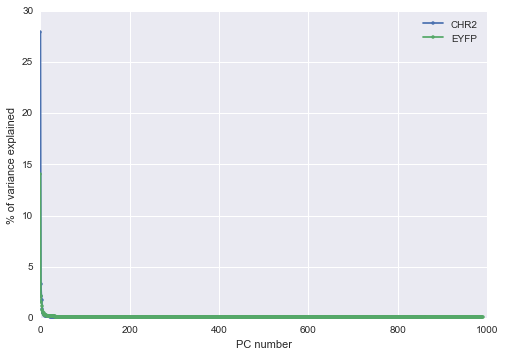

In [15]:
fig, ax = plt.subplots()
for condition in conditions:
    plot_variance_explained_per_pc(pca_results_paths[condition],fig,ax, label=condition)

ax.legend(loc='upper right')
fig.show()

Save the above figure if needed

In [18]:
figfile = os.path.join(results_directory,'Percent_variance_explained_by_pcs')
fig.savefig(figfile+'.png',format='png',dpi=300)

The next important thing to check is how the traces of activation in the PCA space look. If none of the PCs contain a strong stimulation evoked response, it is likely that there is no stimulation effect. Further, from the above plot of the fraction of variance explained, one can see that only the first 3 or so PCs are likely going to be representing anything interesting. Whether or not this representation is stimulation related is something that we will check by plotting the traces below.

It is a good idea to not save all the figure handles separately when plotting them. This will use a lot of memory and likely crash your computer. So save the figures immediately if you wish to save them into a directory so that you can scroll through the figures. Also, once the figures are saved, it's a good idea to clear all those handles so as to clear memory.


In [19]:
for condition in conditions:
    data_in_pcaspace = PCA_decomp(mean_data_for_condition[condition], pca_results_paths[condition], indices_for_windows)
    for pc in range(20):#data_in_pcaspace.shape[0]
        fig = plot_pc_traces(data_in_pcaspace, pc)
        fig.savefig(os.path.join(results_directory,condition,'PC%d_trace.png'%pc), format='png')
        fig.clf() #Use this if you don't want all figures displayed in the Jupyter notebook.

/home/stuberlab/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/stuberlab/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
reset_selective fig

Based on the plots of the PC traces, it is clear that there is one PC that represents the stimulation evoked response.
There are also other PCs that represent interesting things but are likely noise-related. 

The next important thing to check is how the PCA vectors look. This will instruct as to what voxels contribute to each PC. This way of looking at things is interesting to infer what voxels might be affected by the stimulation. Of course, an important caveat is that the PCA vector might not just represent stimulation evoked variability. We can check whether there's evidence to support this notion later by evaluating the PC vectors across multiple stimulations. If these vectors are similar across the multiple stimulations, then each PC vector likely represents mostly stimulation related variability.

As before, it is a good idea to not save all the figure handles separately when plotting them. This will use a lot of memory and likely crash your computer. So save the figures immediately if you wish to save them into a directory so that you can scroll through the figures. Also, once the figures are saved, it's a good idea to clear all those handles so as to clear memory.

In [20]:
for condition in conditions:
    data_in_pcaspace = PCA_decomp(mean_data_for_condition[condition], pca_results_paths[condition], indices_for_windows)
    for pc in range(20):#data_in_pcaspace.shape[0]
        fig = plot_pc_vectors(pca_results_paths[condition], (numx, numy, numz), pc)
        fig.savefig(os.path.join(results_directory,condition,'PC%d_vector.png'%pc), format='png')
        fig.clf() #Use this if you don't want all figures displayed in the Jupyter notebook.

In [21]:
reset_selective fig

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Now that we know that the results are interesting, we might want to plot the first PC from both conditions on top of each other for a figure. This is Figure XX in the manuscript. This function is written below and we will call it immediately after the definition.

In [16]:
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = vector_of_pvals
    correctedpvals[orderofpvals[k:]] = 1
    return correctedpvals


def select_pcs_with_significant_evoked_responses(data,
                                                 stimoffsets,
                                                 pca_results_paths,
                                                 indices_for_windows,
                                                 periodofinterest='stim'):
    significantpcs_for_condition = {}
    ttestresults_for_condition = {}
    conditions = data.keys()
    conditions.sort()
    
    for condition in conditions:
        datainpcaspace = transform_from_loadedpca(data[condition], pca_results_paths[condition])
        numpcs = datainpcaspace.shape[0]
        ttestresults_per_pc = np.nan*np.ones((numpcs,2,len(stimoffsets)))       

        
        
        poststimslope = np.nan*np.ones((numpcs,len(stimoffsets)))#slope of post stim response for all stims
        
        for pc in range(numpcs):
            for s, stim in enumerate(stimoffsets):
                poststimperiod = np.arange(indices_for_windows[stim],indices_for_windows[stim+1])
                stimperiod = np.arange(indices_for_windows[stim-1],indices_for_windows[stim])
                baselineperiod = np.arange(indices_for_windows[stim-2],indices_for_windows[stim-1])
                
                baseline = datainpcaspace[pc,baselineperiod]
                if periodofinterest=='poststim':
                    signal = datainpcaspace[pc, poststimperiod]
                elif periodofinterest=='stim':
                    signal = datainpcaspace[pc, stimperiod]
                ttestresults_per_pc[pc,:,s] = stats.ttest_ind(signal, baseline, equal_var=False)

                trace = datainpcaspace[pc, poststimperiod].T
                time = np.arange(trace.shape[0]).T
                time = sm.add_constant(time)
                lm = sm.OLS(trace, time).fit()
                poststimslope[pc,s] = lm.params[1]
            
        doespcmeetcriteria = np.nan*np.ones((numpcs, len(stimoffsets)))
        for s, stim in enumerate(stimoffsets):
            ttestresults_per_pc[:,1,s] = Benjamini_Hochberg_correction(ttestresults_per_pc[:,1,s]) #FDR corrected pvals
            
            #Calculate PCs with positive stim response to every stim
            tempsignificantpcs1 = ttestresults_per_pc[:,0,s]>0
            #Calculate PCs with decreasing post stim response trace to every stim
            tempsignificantpcs2 = poststimslope[:,s]<0
            doespcmeetcriteria[:,s]= np.logical_and(tempsignificantpcs1,tempsignificantpcs2).astype(int)
        #Select PCs that show all of the above
        significantpcs = np.where(np.sum(doespcmeetcriteria, axis=1)==len(stimoffsets))
        
        significantpcs_for_condition[condition] = significantpcs
        ttestresults_for_condition[condition] = ttestresults_per_pc
    return significantpcs_for_condition, ttestresults_for_condition

def overlay_pc_traces_from_all_conditions(data_for_conditions, 
                                    pca_results_paths,
                                    colors_for_conditions,
                                    pc_of_interest, 
                                    indices_for_windows):
    # This function overlays corresponding PCs across all conditions on a single plot.
    # This is useful if one wants to compare the PC traces between both conditions
    # without each PC being normalized within itself. It only plots one PC at a time.
    # That PC is specified by pc_of_interest
    
    # Parameters:
    # data_for_conditions: The data from all conditions organized in a dictionary
    #                      on which the PCA was performed.
    # pca_results_paths  : Note that this should be a dictionary of the PCA results
    #                      paths for ALL conditions. This is different from the
    #                      variable pca_results_path which was used in earlier 
    #                      functions.
    # indices_for_windows: Calculated previously in the raw data visualization.
    # pc_of_interest     : Which PC number to plot for either condition. 
    # colors_for_conditions: A list specifying the colors for the conditions.
    
    # Returns: Figure handle for the plot
    
    fig, ax = plt.subplots()
    trace_for_condition = np.nan*np.ones((2,indices_for_windows[-1]))
    conditions = data_for_conditions.keys()
    conditions.sort()
    
    for c, condition in enumerate(conditions):
        dataforpca = data_for_conditions[condition]
        data_in_pcaspace = PCA_decomp(dataforpca, pca_results_paths[condition], indices_for_windows)
        temp = (data_in_pcaspace[pc_of_interest[c],:])
        # This makes sure that the mean value of the traces in the last 10s of
        # baseline are equal between all conditions.
        trace_for_condition[c,:] = temp-np.mean(temp[10:indices_for_windows[1]])
        
    normalization = np.amax(trace_for_condition)
    lowest = np.amin(trace_for_condition)
    ylimlow = lowest/normalization*1.05;ylimhigh = 1.05    
    
    for c, condition in enumerate(conditions):
        trace = trace_for_condition[c,:]/normalization
        ax.plot(trace, colors_for_conditions[c], label=condition)
        if c==0:
            for epochindex in range(1,indices_for_windows.shape[0]-1):
                ax.plot(indices_for_windows[epochindex]*np.array([1, 1]), [ylimlow, ylimhigh], '--k', linewidth=1)
    ax.set_ylim([ylimlow, ylimhigh])
    ax.set_ylabel('Normalized PC signal (score)')
    ax.set_xlabel('Time (s)')
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig

In [17]:
stimoffsets = [2,5]
for i in range(19):
    stimoffsets.append(stimoffsets[-1]+2)
stimoffsets.append(stimoffsets[-1]+3)

significantpcs, ttestresults = select_pcs_with_significant_evoked_responses(mean_data_for_condition,
                                                 stimoffsets,
                                                 pca_results_paths,
                                                 indices_for_windows)

Found compressed data
Found compressed data


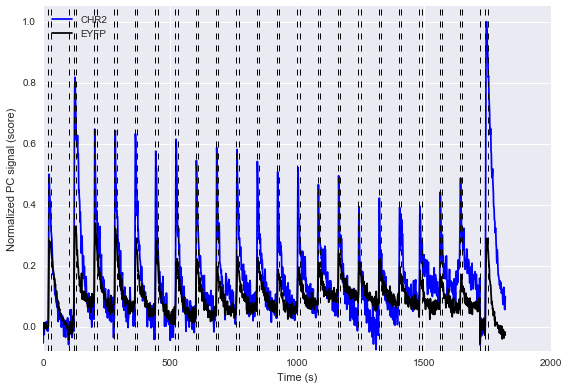

In [19]:
fig=overlay_pc_traces_from_all_conditions(mean_data_for_condition, 
                                    pca_results_paths,
                                    ['b','k'],
                                    [significantpcs['CHR2'][0][0], significantpcs['EYFP'][0][0]], 
                                    indices_for_windows)

In [24]:
fig.savefig(os.path.join(results_directory,'overlaid_traces.png'), format='png', dpi=300)
fig.savefig(os.path.join(results_directory,'overlaid_traces.pdf'), format='pdf')

## Plot evolution of CHR2:EYFP ratio over pairings

In [108]:
def calculate_evoked_response_for_pairing(data_for_conditions,
                                          stimstarttimes,
                                          pca_results_paths, 
                                          colors_for_conditions,
                                          pc_of_interest):
    
    fig, ax = plt.subplots(2, figsize=(10,10))
    peak_for_pairing = np.nan*np.ones((2,stimstarttimes.shape[0]))
    conditions = data_for_conditions.keys()
    conditions.sort()
    
    responseforpairings = {}
    for c, condition in enumerate(conditions):
        dataforpca = data_for_conditions[condition]
        data_in_pcaspace = PCA_decomp(dataforpca, pca_results_paths[condition], indices_for_windows)
        temp = (data_in_pcaspace[pc_of_interest[c],:])
        baselineforpairings = np.nan*np.ones((stimstarttimes.shape[0],))
        peakresponseforpairings = np.nan*np.ones((stimstarttimes.shape[0],))
        for pairing in range(stimstarttimes.shape[0]):
            baselineforpairings[pairing] = np.mean(temp[(stimstarttimes[pairing]-10):stimstarttimes[pairing]])
            peakresponseforpairings[pairing] = np.amax(temp[(stimstarttimes[pairing]):stimstarttimes[pairing]+10])
            
        responseforpairings[condition] = peakresponseforpairings-baselineforpairings    
        
    responseratioforpairings = np.divide(responseforpairings['CHR2'], responseforpairings['EYFP'])
    lm = sm.OLS(responseratioforpairings, sm.add_constant(np.arange(responseratioforpairings.shape[0]))).fit()
    print 'Results for the testing of whether response ratio increases with pairing\n\n'
    print lm.summary()
    
    print '\n\n\n\n\n\nHabituation response summary for the CHR2 group\n\n'
    print sm.OLS(responseforpairings['CHR2'][1:-1]/responseforpairings['CHR2'][0],
                 sm.add_constant(np.arange(1,stimstarttimes.shape[0]-1))).fit().summary()
    
    print '\n\n\n\n\n\nHabituation response summary for the EYFP group\n\n'
    print sm.OLS(responseforpairings['EYFP'][1:-1]/responseforpairings['EYFP'][0],
                 sm.add_constant(np.arange(1,stimstarttimes.shape[0]-1))).fit().summary()
    
    responseforpairings_df = pd.DataFrame(np.column_stack((responseforpairings['CHR2'][1:-1]/responseforpairings['CHR2'][0], 
                                                          ['CHR2']*(stimstarttimes.shape[0]-2),
                                                          range(1,stimstarttimes.shape[0]-1))),
                                          columns=['Response', 'Group', 'Pairing_number']) 
                                          #created for running ANCOVA using statsmodels
    temp = pd.DataFrame(np.column_stack((responseforpairings['EYFP'][1:-1]/responseforpairings['EYFP'][0], 
                                                          ['EYFP']*(stimstarttimes.shape[0]-2),
                                                          range(1,stimstarttimes.shape[0]-1))),
                                          columns=['Response', 'Group', 'Pairing_number']) 
                                          #created for running ANCOVA using statsmodels
    responseforpairings_df = responseforpairings_df.append(temp, ignore_index=True)
    responseforpairings_df['Response'] = responseforpairings_df['Response'].astype(float)
    responseforpairings_df['Pairing_number'] = responseforpairings_df['Pairing_number'].astype(int)
    lm = smf.ols(formula='Response ~ Pairing_number*C(Group)', data=responseforpairings_df).fit()
    print '\n\nResults for the testing of whether responses decrease with pairing equally for both groups\n\n'
    print responseforpairings_df
    print lm.summary()
    table = sm.stats.anova_lm(lm)
    print table
    
    ax[0].plot(responseratioforpairings,'.-')
    ax[0].set_ylabel('Ratio of responses')
    ax[0].set_xlabel('Paw stim number')
    
    for c, condition in enumerate(conditions):
        temp = responseforpairings[condition]
        temp = temp/temp[0]
        ax[1].plot(temp, '.-', color=colors_for_conditions[c], label=condition)
    ax[1].set_ylabel('Response normalized to pre response')
    ax[1].set_xlabel('Paw stim number')
    ax[1].legend(loc='upper right')
    fig.tight_layout()
    return fig, ax

In [23]:
stimstarttimeidxs = np.argwhere(np.diff(indices_for_windows)==10)
stimstarttimes = indices_for_windows[stimstarttimeidxs]

Results for the testing of whether response ratio increases with pairing


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     9.982
Date:                Mon, 15 Feb 2016   Prob (F-statistic):            0.00493
Time:                        17:42:56   Log-Likelihood:                -10.784
No. Observations:                  22   AIC:                             25.57
Df Residuals:                      20   BIC:                             27.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------

/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/stuberlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


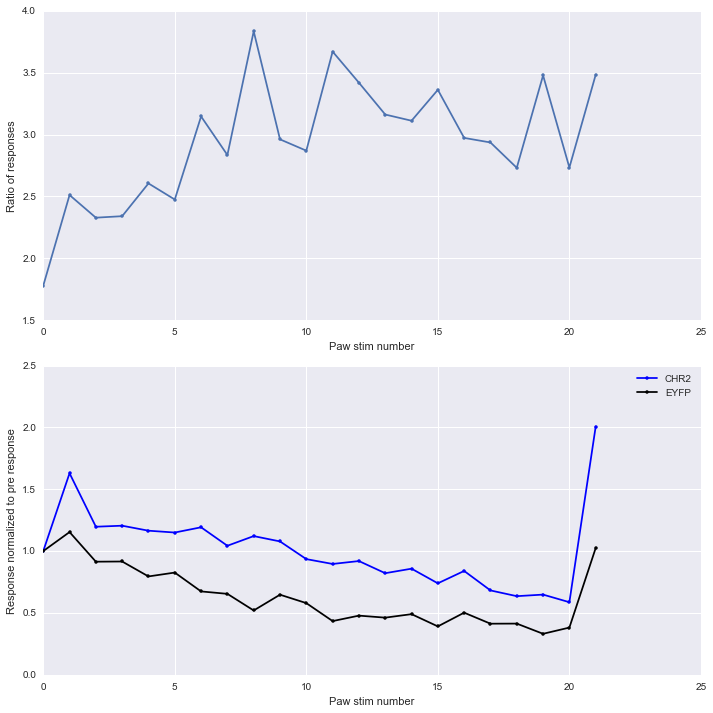

In [109]:
fig, ax = calculate_evoked_response_for_pairing(mean_data_for_condition,
                                          stimstarttimes,
                                          pca_results_paths, 
                                          ['b','k'],
                                          [significantpcs['CHR2'][0][0], significantpcs['EYFP'][0][0]])

In [21]:
fig.savefig(os.path.join(results_directory,'response_evolution_over_pairing.png'), format='png', dpi=300)
fig.savefig(os.path.join(results_directory,'response_evolution_over_pairing.pdf'), format='pdf')